# Preparation and testing of model specification

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
from pathlib import Path
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from matplotlib.lines import Line2D

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/docs/design_notes/omnistaging.md.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.


In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.io import DataFile, data_path
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

# Constants
SEED = 847
np.random.seed(SEED)
arviz_config()

## Data

In [5]:
def _broad_only(df: pd.DataFrame) -> pd.DataFrame:
    return df.query("screen == 'broad'").reset_index(drop=True)

In [6]:
crispr_data_manager = CrisprScreenDataManager(
    DataFile.DEPMAP_CRC_SUBSAMPLE, transformations=[_broad_only]
)
crc_data = crispr_data_manager.get_data()

In [7]:
for col in ["sgrna", "hugo_symbol", "depmap_id"]:
    print(f"'{col}': {crc_data[col].nunique()}")

'sgrna': 162
'hugo_symbol': 103
'depmap_id': 8


## Distributions

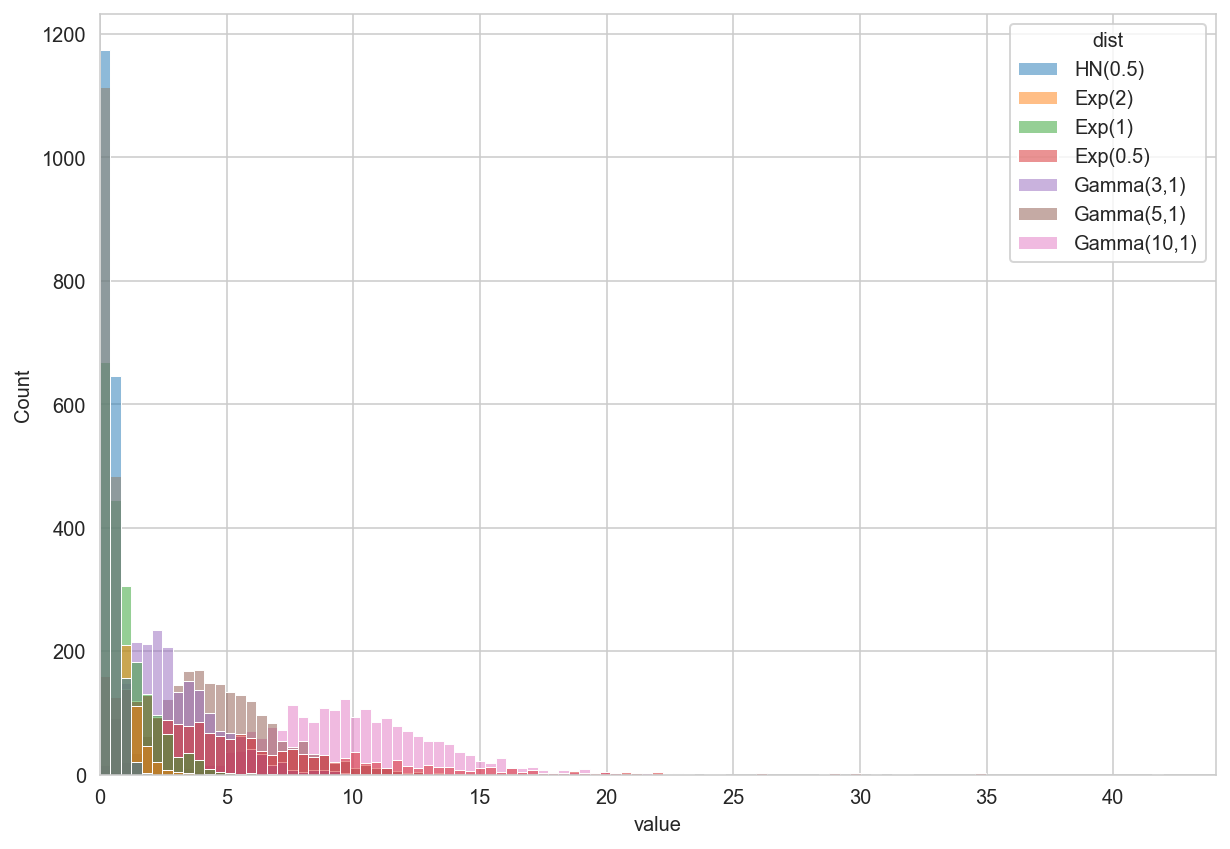

In [8]:
N = 2000
df = pd.DataFrame()
df = pd.concat(
    [
        df,
        pd.DataFrame({"value": pm.draw(pm.HalfNormal.dist(0.5), N), "dist": "HN(0.5)"}),
        pd.DataFrame({"value": pm.draw(pm.Exponential.dist(2), N), "dist": "Exp(2)"}),
        pd.DataFrame({"value": pm.draw(pm.Exponential.dist(1), N), "dist": "Exp(1)"}),
        pd.DataFrame(
            {"value": pm.draw(pm.Exponential.dist(0.2), N), "dist": "Exp(0.5)"}
        ),
        pd.DataFrame({"value": pm.draw(pm.Gamma.dist(3, 1), N), "dist": "Gamma(3,1)"}),
        pd.DataFrame({"value": pm.draw(pm.Gamma.dist(5, 1), N), "dist": "Gamma(5,1)"}),
        pd.DataFrame(
            {"value": pm.draw(pm.Gamma.dist(10, 1), N), "dist": "Gamma(10,1)"}
        ),
    ]
).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=df, x="value", hue="dist", ax=ax)
ax.set_xlim(0, None)
plt.show()

In [9]:
df.groupby("dist").describe()

value                                                     \
              count       mean       std       min       25%       50%   
dist                                                                     
Exp(0.5)     2000.0   5.096003  5.042091  0.000748  1.521280  3.610589   
Exp(1)       2000.0   0.994186  0.956910  0.000286  0.286173  0.688827   
Exp(2)       2000.0   0.511599  0.517408  0.000417  0.145785  0.350494   
Gamma(10,1)  2000.0  10.064206  3.172722  2.603871  7.743451  9.757335   
Gamma(3,1)   2000.0   3.016068  1.760194  0.166258  1.690546  2.616145   
Gamma(5,1)   2000.0   4.950315  2.238334  0.361734  3.332061  4.605046   
HN(0.5)      2000.0   0.393975  0.298890  0.000341  0.153811  0.332436   

                                   
                   75%        max  
dist                               
Exp(0.5)      7.150561  41.953588  
Exp(1)        1.389971   6.780838  
Exp(2)        0.706067   4.434141  
Gamma(10,1)  12.002344  22.671441  
Gamma(3,1)    3.958118  11.738172  
Gamma(5,1)    6.194679  16.912828  
HN(0.5)       0.574717   1.817445

(0.0, 94.5)

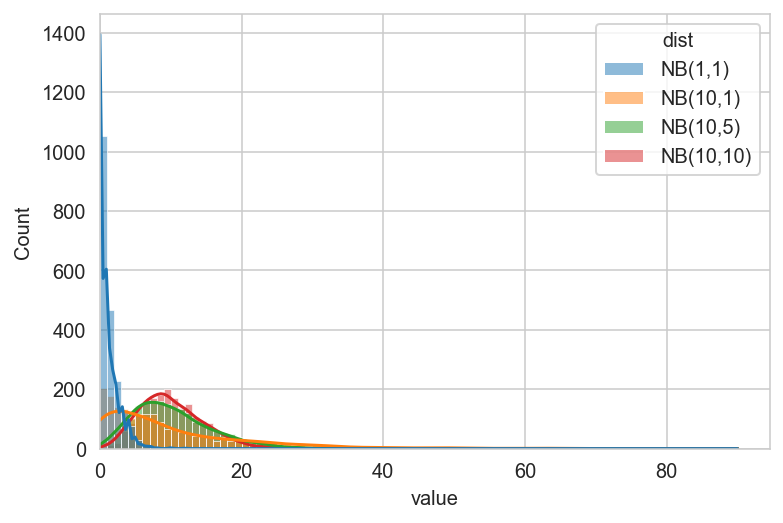

In [10]:
N = 2000
df = pd.DataFrame()
df = pd.concat(
    [
        df,
        pd.DataFrame(
            {"value": pm.draw(pm.NegativeBinomial.dist(1, 1), N), "dist": "NB(1,1)"}
        ),
        pd.DataFrame(
            {"value": pm.draw(pm.NegativeBinomial.dist(10, 1), N), "dist": "NB(10,1)"}
        ),
        pd.DataFrame(
            {"value": pm.draw(pm.NegativeBinomial.dist(10, 5), N), "dist": "NB(10,5)"}
        ),
        pd.DataFrame(
            {
                "value": pm.draw(pm.NegativeBinomial.dist(10, 10), N),
                "dist": "NB(10,10)",
            }
        ),
    ]
)
df = df.reset_index(drop=True)
ax = sns.histplot(data=df, x="value", hue="dist", kde=True, binwidth=1)
ax.set_xlim(0, None)

## Modeling

In [43]:
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel

[autoreload of speclet.bayesian_models.lineage_hierarchical_nb failed: Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "pyda

In [44]:
crc_model = LineageHierNegBinomModel(lineage="colorectal")
valid_crc_data = crc_model.data_processing_pipeline(crc_data.copy())

[07/24/22 14:58:08] INFO     Processing data for modeling.     ]8;id=640913;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=841141;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#268\268]8;;\

INFO:speclet:Processing data for modeling.


                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=363583;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=676848;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#269\269]8;;\

INFO:speclet:LFC limits: (-5.0, 5.0)


[07/24/22 14:58:09] WARNING  number of data points dropped: 0  ]8;id=144399;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=689520;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#320\320]8;;\

                    INFO     Processing data for modeling.     ]8;id=148196;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=423121;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#268\268]8;;\

INFO:speclet:Processing data for modeling.


                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=24399;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=228821;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#269\269]8;;\

INFO:speclet:LFC limits: (-5.0, 5.0)


[07/24/22 14:58:10] WARNING  number of data points dropped: 0  ]8;id=513052;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=677560;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#320\320]8;;\

                    INFO     Lineage: colorectal               ]8;id=791384;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=132067;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#324\324]8;;\

INFO:speclet:Lineage: colorectal


                    INFO     Number of genes: 103              ]8;id=936316;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=721382;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#325\325]8;;\

INFO:speclet:Number of genes: 103


                    INFO     Number of sgRNA: 162              ]8;id=1430;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=334510;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#326\326]8;;\

INFO:speclet:Number of sgRNA: 162


                    INFO     Number of cell lines: 8           ]8;id=458238;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=834198;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#327\327]8;;\

INFO:speclet:Number of cell lines: 8


                    INFO     Number of cancer genes: 3         ]8;id=271235;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=919581;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#328\328]8;;\

INFO:speclet:Number of cancer genes: 3


                    INFO     Number of screens: 1              ]8;id=651378;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=689079;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#329\329]8;;\

INFO:speclet:Number of screens: 1


                    INFO     Number of data points: 1296       ]8;id=992154;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=586212;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#330\330]8;;\

INFO:speclet:Number of data points: 1296


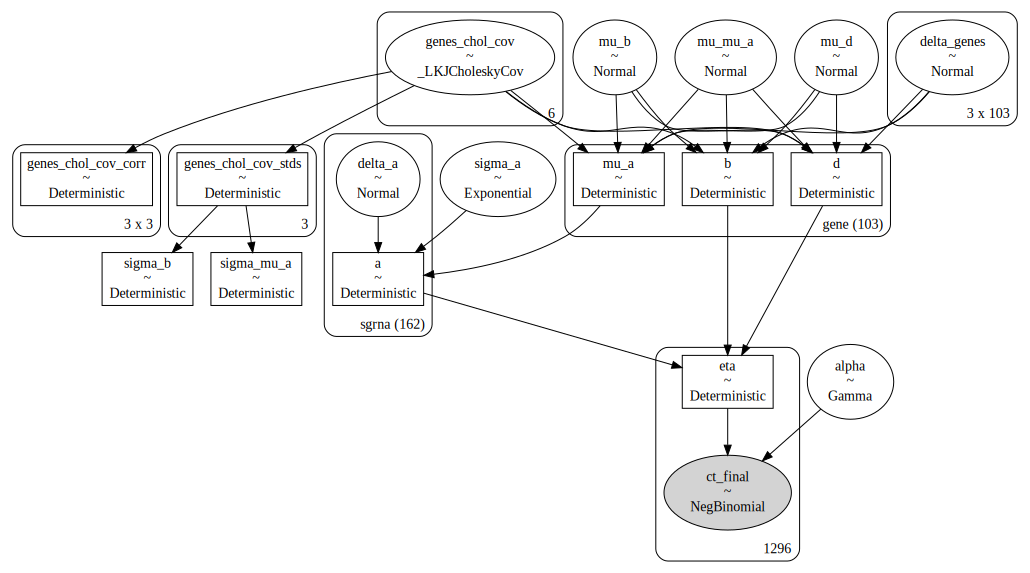

In [45]:
crc_pymc_model = crc_model.pymc_model(crispr_data_manager.data.copy())
pm.model_to_graphviz(crc_pymc_model)

In [46]:
with crc_pymc_model:
    pm_prior_pred = pm.sample_prior_predictive(
        var_names=["eta", "ct_final", "mu_a"], random_seed=SEED
    )

print("prior predictive distribution")
pm_pred_draws = pm_prior_pred.prior_predictive["ct_final"].values.squeeze()
for q in np.arange(0, 1.01, 0.1):
    res = np.quantile(pm_pred_draws, q=q)
    print(f"  {int(q*100)}%: {int(res):0,d}")

print("")
obs = valid_crc_data["counts_final"].astype(int)
print(f"final counts\n  min: {np.min(obs):,d},  max: {np.max(obs):,d}")

obs = valid_crc_data["counts_initial_adj"].astype(int)
print(f"initial counts\n  min: {np.min(obs):,d},  max: {np.max(obs):,d}")

prior predictive distribution
  0%: 0
  10%: 36
  20%: 95
  30%: 175
  40%: 286
  50%: 445
  60%: 695
  70%: 1,125
  80%: 2,018
  90%: 4,900
  100%: 868,426,825,321,325,568

final counts
  min: 0,  max: 9,819
initial counts
  min: 57,  max: 4,741


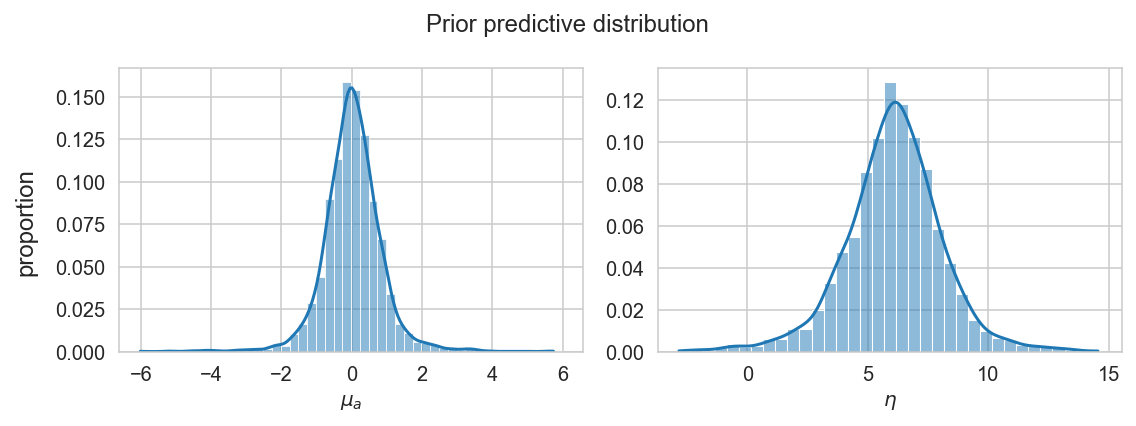

In [47]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
eta_prior = np.random.choice(pm_prior_pred.prior["eta"].values.flatten(), 2000)
mu_prior = np.random.choice(pm_prior_pred.prior["mu_a"].values.flatten(), 4000)
sns.histplot(mu_prior, kde=True, ax=axes[0], binwidth=0.25, stat="proportion")
sns.histplot(eta_prior, kde=True, ax=axes[1], binwidth=0.5, stat="proportion")
axes[0].set_xlabel(r"$\mu_a$")
axes[1].set_xlabel(r"$\eta$")
for ax in axes.flatten():
    ax.set_ylabel(None)
    ax.set_title(None)

fig.supylabel("proportion")
fig.suptitle("Prior predictive distribution")
fig.tight_layout()
plt.show()

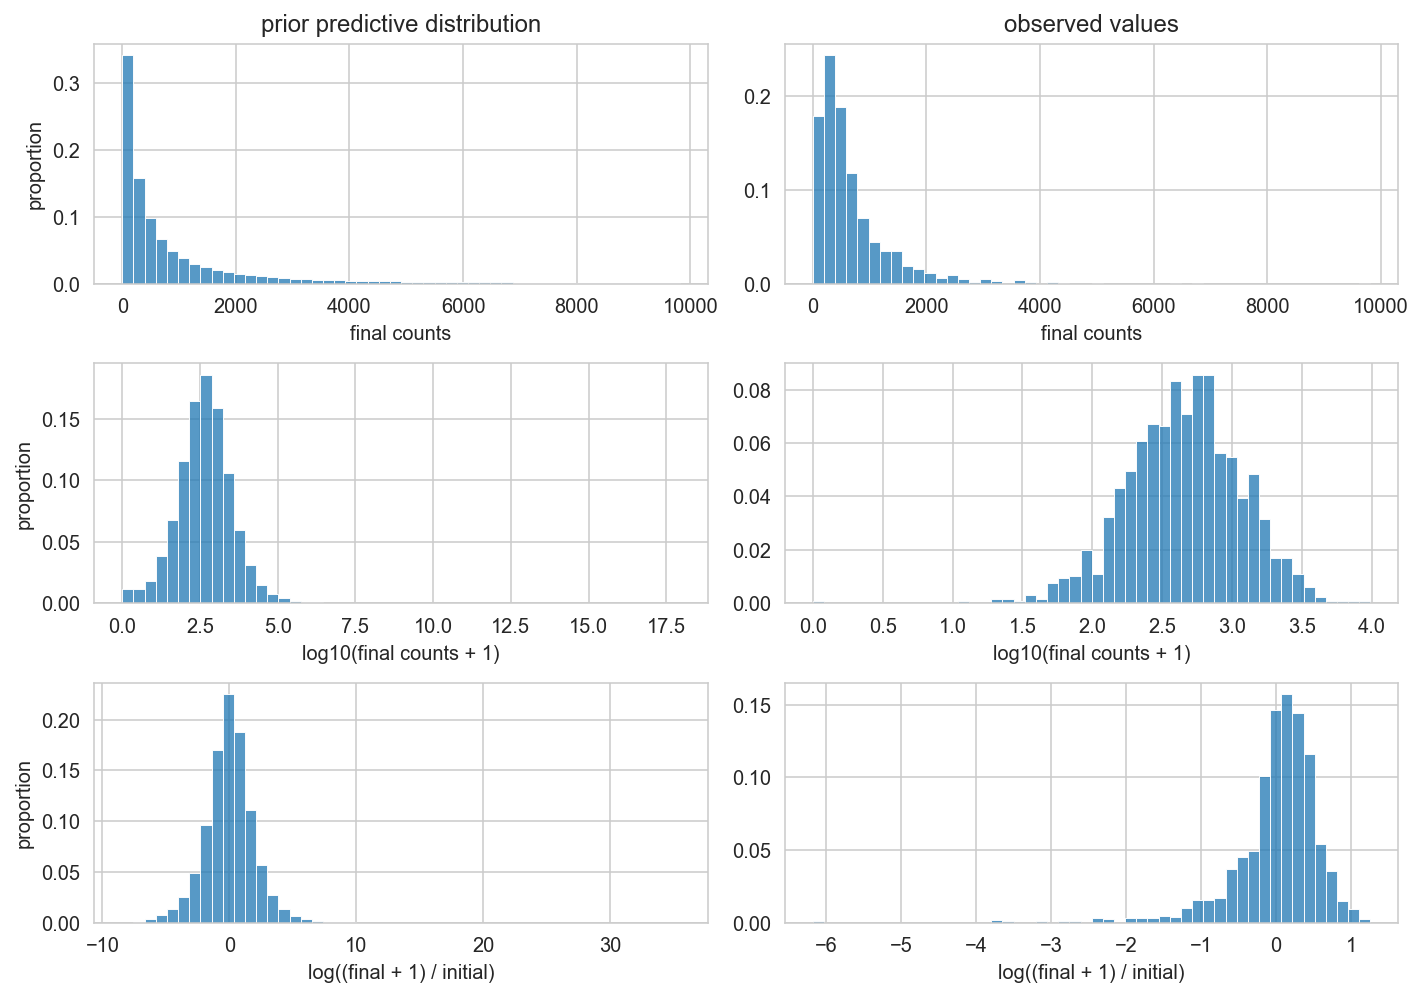

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 7))

stat = "proportion"

obs_max = crc_data["counts_final"].max()
truncated_prior_preds = [x for x in pm_pred_draws.flatten() if x <= obs_max]

# Untransformed
sns.histplot(x=truncated_prior_preds, ax=axes[0, 0], bins=50, stat=stat)
sns.histplot(x=valid_crc_data["counts_final"], ax=axes[0, 1], bins=50, stat=stat)
# Log10 transformed
sns.histplot(x=np.log10(pm_pred_draws.flatten() + 1), ax=axes[1, 0], bins=50, stat=stat)
sns.histplot(
    x=np.log10(valid_crc_data["counts_final"] + 1), ax=axes[1, 1], bins=50, stat=stat
)
# Log-fold change
pp_lfc = np.log(
    (pm_pred_draws + 1) / (valid_crc_data["counts_initial_adj"].values[None, :])
)
obs_lfc = np.log(
    (valid_crc_data["counts_final"] + 1) / valid_crc_data["counts_initial_adj"]
)
sns.histplot(x=pp_lfc.flatten(), ax=axes[2, 0], bins=50, stat=stat)
sns.histplot(x=obs_lfc, ax=axes[2, 1], bins=50, stat=stat)


axes[0, 0].set_title("prior predictive distribution")
axes[0, 1].set_title("observed values")

for ax in axes[0, :]:
    ax.set_xlabel("final counts")

for ax in axes[1, :]:
    ax.set_xlabel("log10(final counts + 1)")

for ax in axes[2, :]:
    ax.set_xlabel("log((final + 1) / initial)")

for ax in axes[:, 0]:
    ax.set_ylabel(stat)
for ax in axes[:, 1]:
    ax.set_ylabel(None)

plt.tight_layout()
plt.show()

## Sampling

In [49]:
with crc_pymc_model:
    trace = pymc.sampling_jax.sample_numpyro_nuts(
        draws=1000,
        tune=1000,
        target_accept=0.8,
        random_seed=SEED,
        idata_kwargs={"log_likelihood": False},
    )
    pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=SEED)

Compiling...
Compilation time =  0:00:05.942657
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:01:59.347372
Transforming variables...
Transformation time =  0:00:01.970767


## Posterior analysis

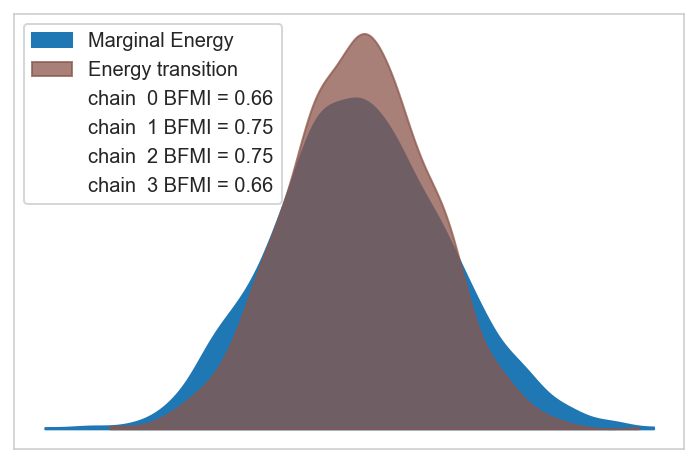

In [50]:
az.plot_energy(trace);

In [51]:
trace.sample_stats.diverging.values.sum(axis=1)

array([0, 0, 0, 0])

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/arviz/utils.py:136: UserWarning: Items starting with ~: ['^mu$', '.*effect$', '^celllines_chol_cov.*$', '^.*celllines$'] have not been found and will be ignored


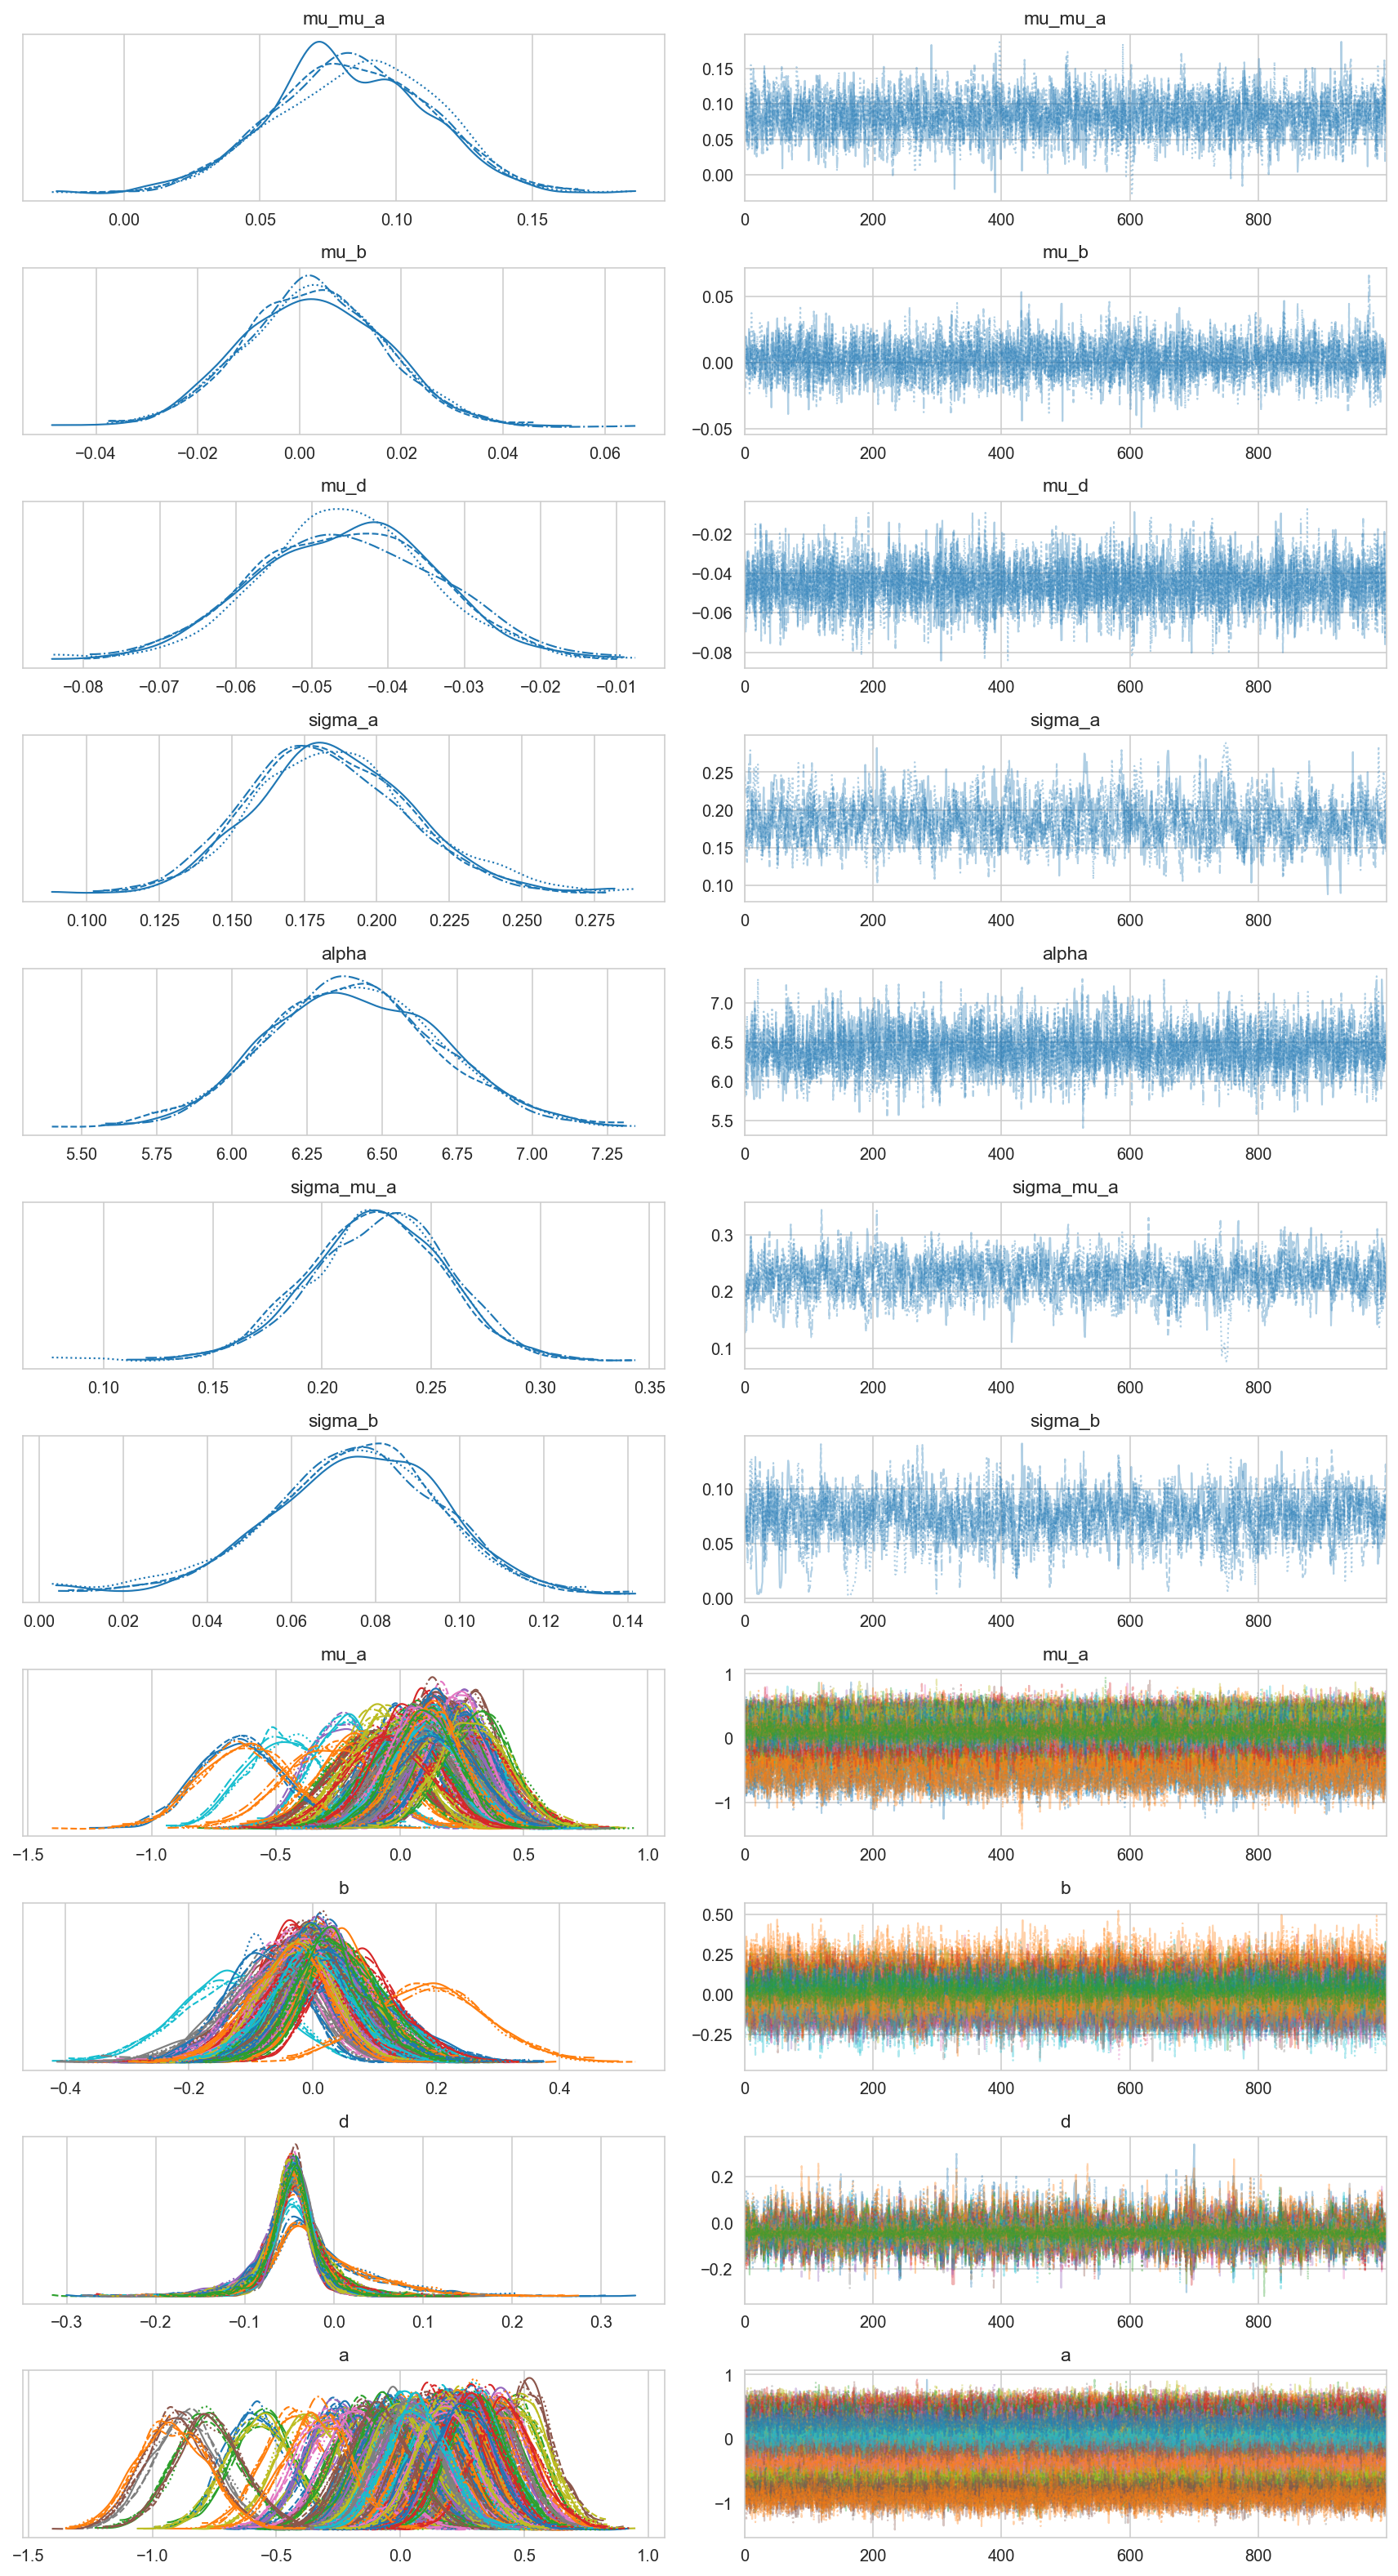

In [52]:
az.plot_trace(trace, var_names=crc_model.vars_regex(), filter_vars="regex")
plt.tight_layout();

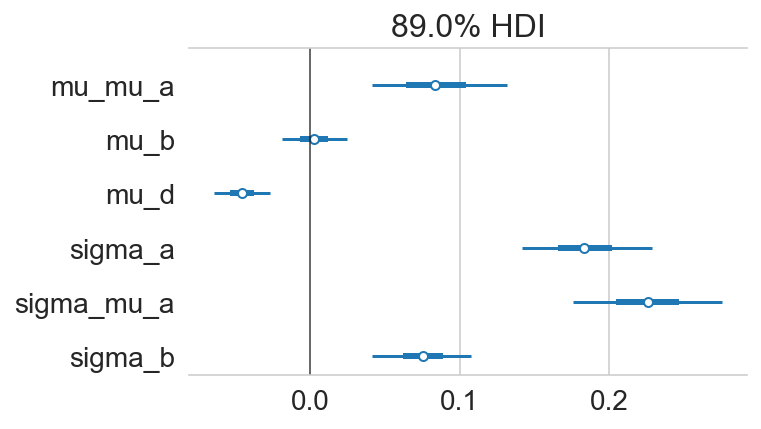

In [53]:
ax = az.plot_forest(
    trace,
    var_names=["mu_mu_a", "mu_b", "mu_d", "^sigma.*$"],
    filter_vars="regex",
    combined=True,
    figsize=(5, 3),
)
ax[0].axvline(color="k", alpha=0.5, linewidth=1)
plt.show()

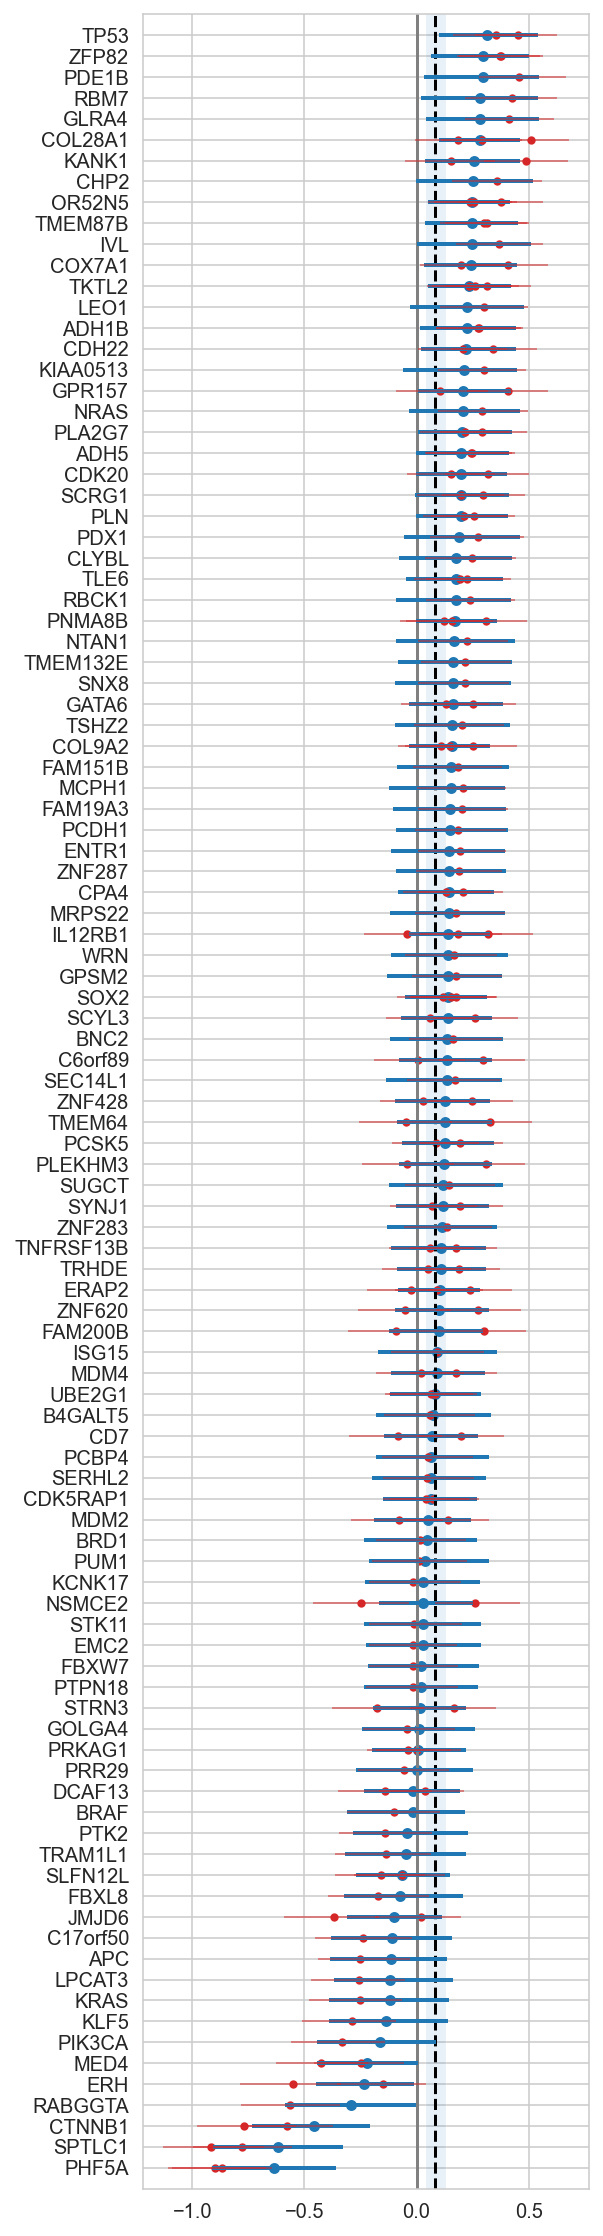

In [54]:
gene_order = (
    az.summary(trace, var_names=["mu_a"], kind="stats")
    .pipe(extract_coords_param_names, names=["hugo_symbol"])
    .sort_values("mean")["hugo_symbol"]
    .tolist()
)

sgrna_to_gene_map = (
    crc_data[["hugo_symbol", "sgrna"]].drop_duplicates().reset_index(drop=True)
)
a_post = (
    az.summary(trace, var_names=["a"], kind="stats")
    .pipe(extract_coords_param_names, names=["sgrna"])
    .reset_index(drop=True)
    .merge(sgrna_to_gene_map, on="sgrna", validate="one_to_one")
)
mu_a_post = (
    az.summary(trace, var_names=["mu_a"], kind="stats")
    .pipe(extract_coords_param_names, names=["hugo_symbol"])
    .reset_index(drop=True)
)

a_post["hugo_symbol"] = pd.Categorical(
    a_post["hugo_symbol"], categories=gene_order, ordered=True
)
a_post = a_post.sort_values("hugo_symbol").reset_index(drop=True)
mu_a_post["hugo_symbol"] = pd.Categorical(
    mu_a_post["hugo_symbol"], categories=gene_order, ordered=True
)
mu_a_post = mu_a_post.sort_values("hugo_symbol").reset_index(drop=True)

mu_mu_a_post = az.summary(trace, var_names=["mu_mu_a"], kind="stats")
assert len(mu_mu_a_post) == 1
mu_mu_a_avg = mu_mu_a_post["mean"][0]
mu_mu_a_hdi = (mu_mu_a_post["hdi_5.5%"][0], mu_mu_a_post["hdi_94.5%"][0])

fig, ax = plt.subplots(figsize=(4, 20))
plt.axvline(0, color="grey")

# Population average and HDI
plt.fill_between(x=mu_mu_a_hdi, y1=-1, y2=len(mu_a_post), alpha=0.1)
plt.axvline(mu_mu_a_avg, color="k", linestyle="--")

# Gene estimates.
plt.hlines(
    y=mu_a_post["hugo_symbol"],
    xmin=mu_a_post["hdi_5.5%"],
    xmax=mu_a_post["hdi_94.5%"],
    color="tab:blue",
    linewidth=2,
)
plt.scatter(x=mu_a_post["mean"], y=mu_a_post["hugo_symbol"], s=20, c="tab:blue")

# sgRNA estimates.
plt.hlines(
    y=a_post["hugo_symbol"],
    xmin=a_post["hdi_5.5%"],
    xmax=a_post["hdi_94.5%"],
    color="tab:red",
    linewidth=1,
    alpha=0.5,
)
plt.scatter(x=a_post["mean"], y=a_post["hugo_symbol"], s=10, c="tab:red")

plt.ylim(-1, len(mu_a_post))
plt.show()

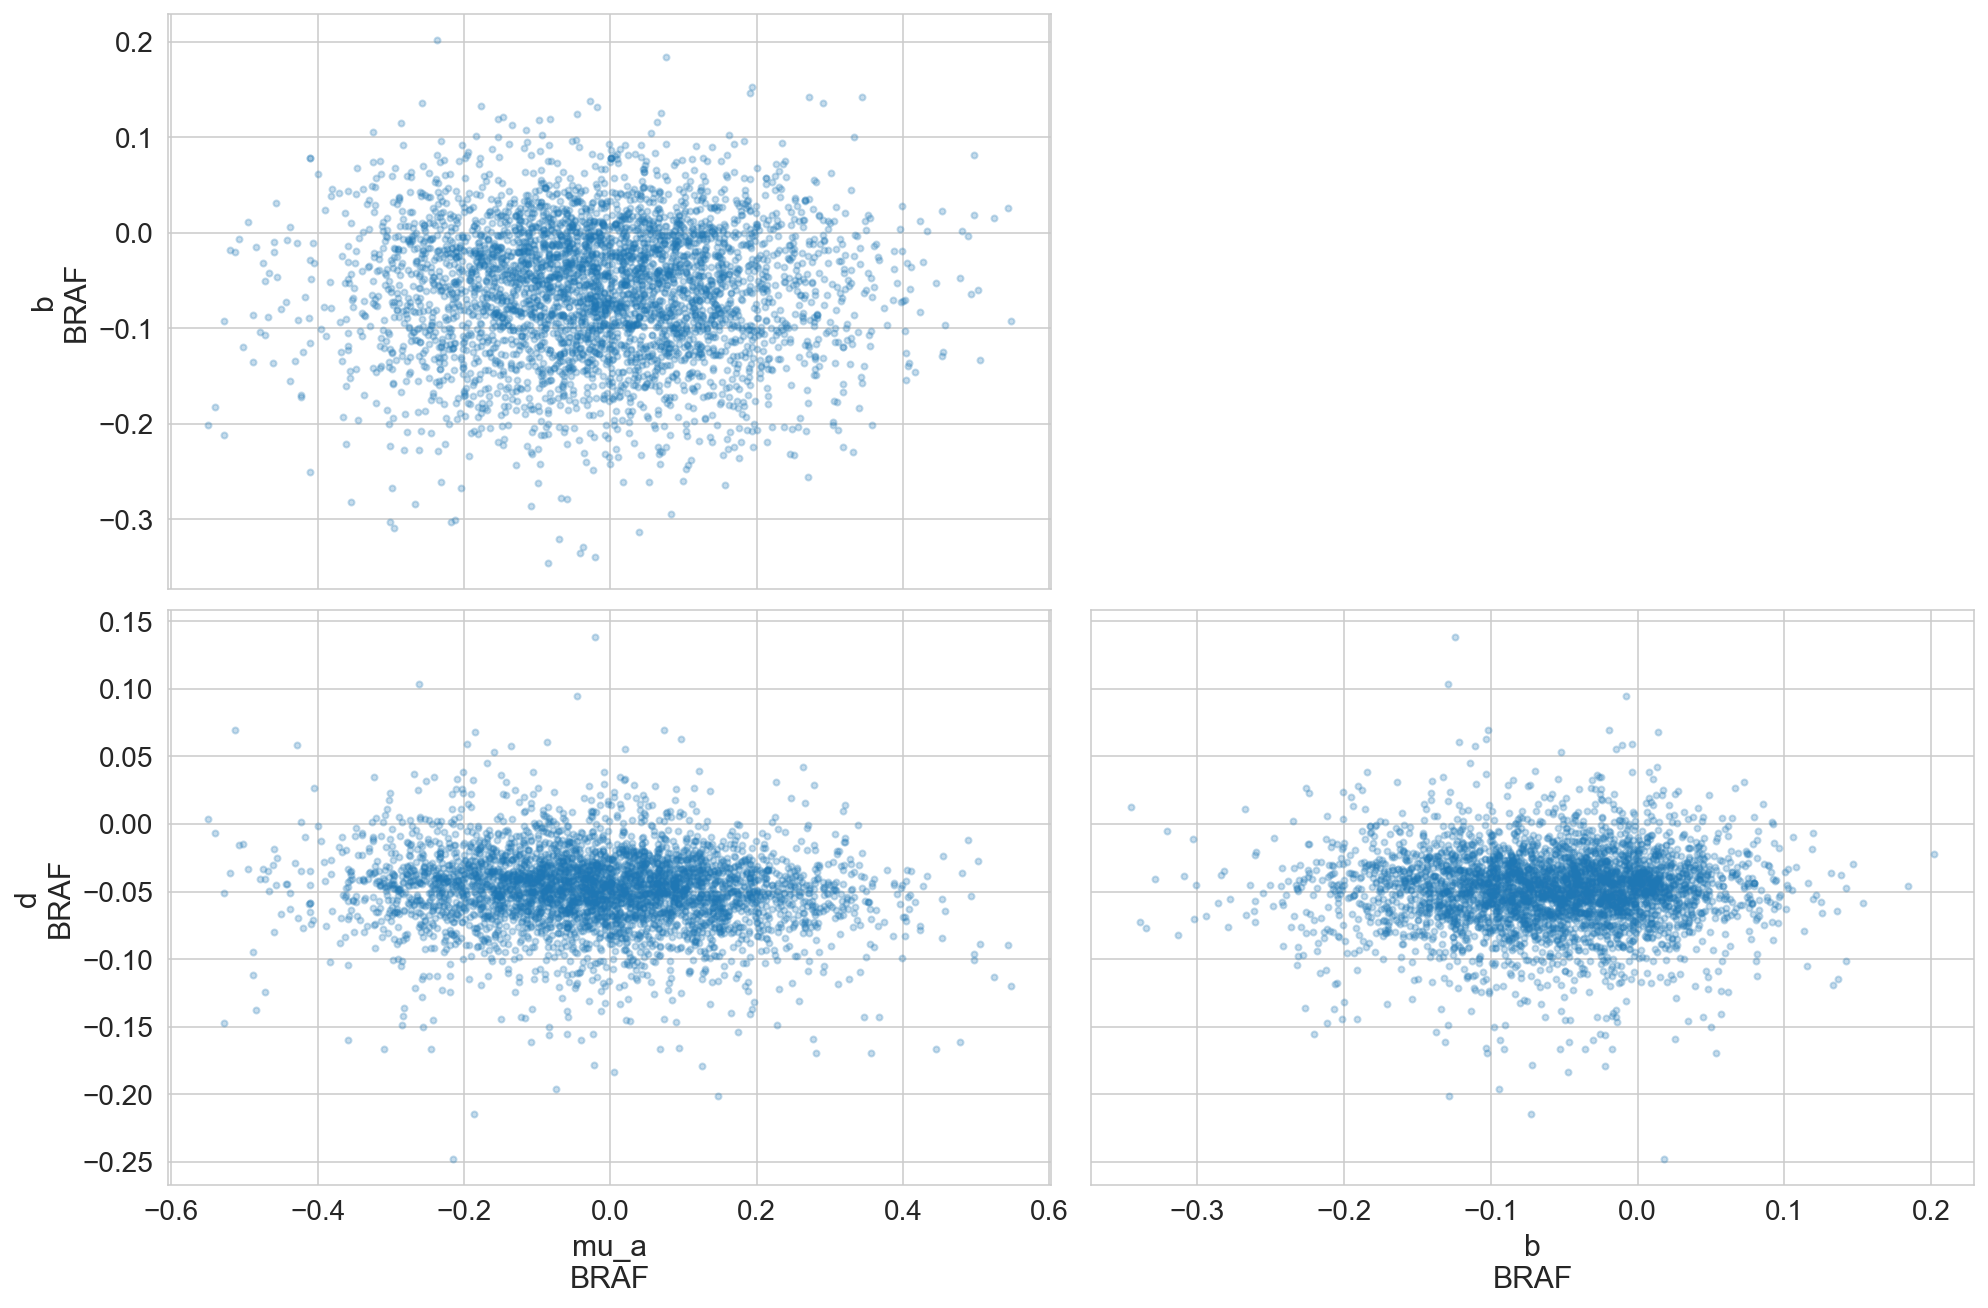

In [62]:
az.plot_pair(
    trace,
    var_names=["mu_a", "b", "d"],
    coords={"gene": ["BRAF"]},
    scatter_kwargs={"alpha": 0.25},
)
plt.tight_layout()
plt.show()

In [56]:
gene_vars = ["$\mu_a$", "$b$", "$d$"]
gene_corr_post = (
    az.summary(trace, var_names=["genes_chol_cov_corr"], kind="stats")
    .pipe(extract_coords_param_names, names=["d0", "d1"])
    .astype({"d0": int, "d1": int})
    .assign(
        p0=lambda d: [gene_vars[i] for i in d["d0"]],
        p1=lambda d: [gene_vars[i] for i in d["d1"]],
    )
)
gene_corr_post

mean     sd  hdi_5.5%  hdi_94.5%  d0  d1       p0  \
genes_chol_cov_corr[0, 0]  1.000  0.000     1.000      1.000   0   0  $\mu_a$   
genes_chol_cov_corr[0, 1] -0.082  0.235    -0.453      0.298   0   1  $\mu_a$   
genes_chol_cov_corr[0, 2] -0.146  0.372    -0.767      0.431   0   2  $\mu_a$   
genes_chol_cov_corr[1, 0] -0.082  0.235    -0.453      0.298   1   0      $b$   
genes_chol_cov_corr[1, 1]  1.000  0.000     1.000      1.000   1   1      $b$   
genes_chol_cov_corr[1, 2]  0.105  0.385    -0.501      0.721   1   2      $b$   
genes_chol_cov_corr[2, 0] -0.146  0.372    -0.767      0.431   2   0      $d$   
genes_chol_cov_corr[2, 1]  0.105  0.385    -0.501      0.721   2   1      $d$   
genes_chol_cov_corr[2, 2]  1.000  0.000     1.000      1.000   2   2      $d$   

                                p1  
genes_chol_cov_corr[0, 0]  $\mu_a$  
genes_chol_cov_corr[0, 1]      $b$  
genes_chol_cov_corr[0, 2]      $d$  
genes_chol_cov_corr[1, 0]  $\mu_a$  
genes_chol_cov_corr[1, 1]      $b$  
genes_chol_cov_corr[1, 2]      $d$  
genes_chol_cov_corr[2, 0]  $\mu_a$  
genes_chol_cov_corr[2, 1]      $b$  
genes_chol_cov_corr[2, 2]      $d$

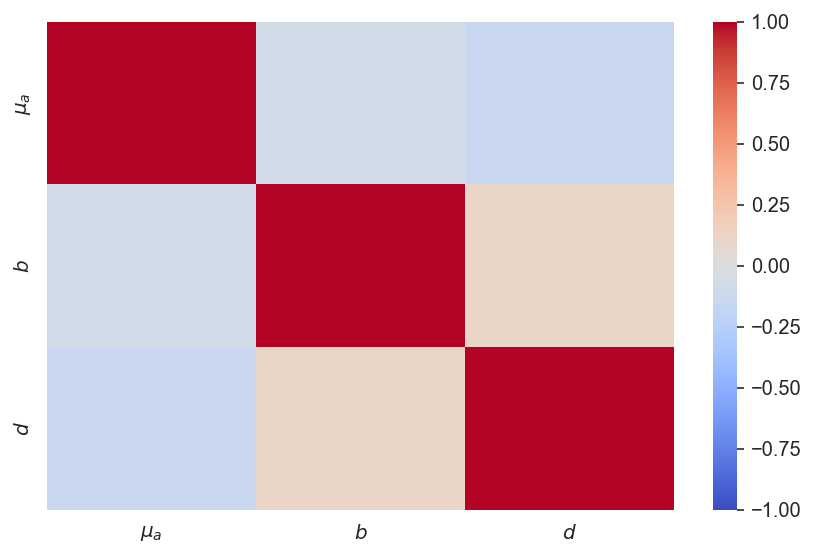

In [57]:
plot_df = gene_corr_post.pivot_wider(
    "p0", names_from="p1", values_from="mean"
).set_index("p0")
ax = sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.tight_layout()
plt.show()

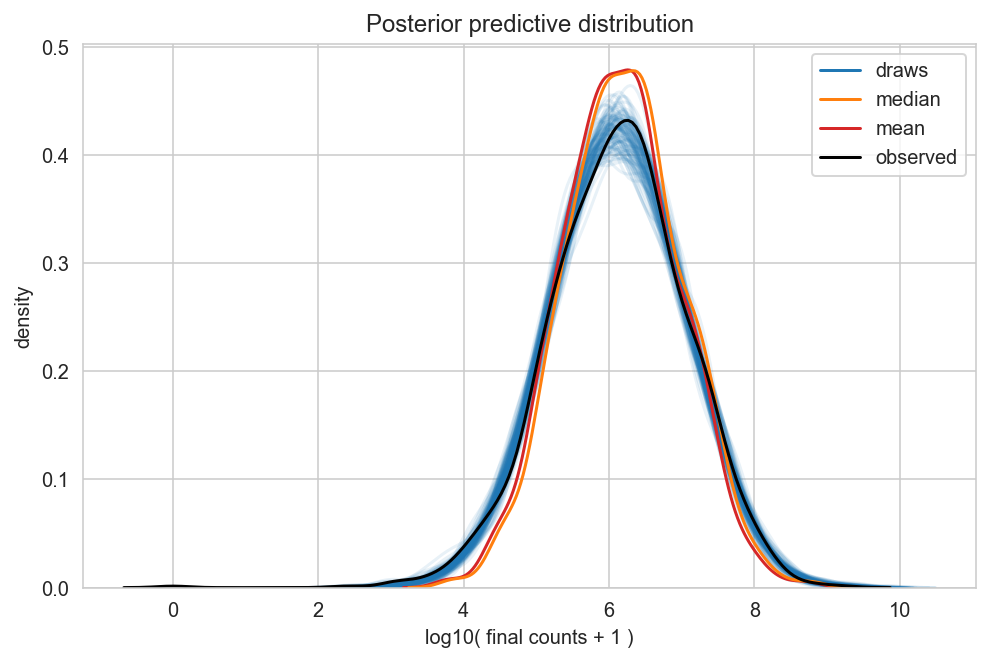

In [58]:
N = 100

pp_dist = trace.posterior_predictive["ct_final"]
n_chains, n_draws, n_samples = pp_dist.shape
draws_idx = np.random.choice(np.arange(n_draws), N // n_chains, replace=False)

fig, ax = plt.subplots(figsize=(8, 5))

pal = {
    "draws": "tab:blue",
    "median": "tab:orange",
    "mean": "tab:red",
    "observed": "black",
}

# Example draws.
for c, d in product(range(n_chains), draws_idx):
    values = np.log(pp_dist[c, d, :].values + 1)
    sns.kdeplot(values, color=pal["draws"], alpha=0.1, ax=ax)

# Average distributions.
pp_dist_mean = np.log(pp_dist.median(axis=(0, 1)) + 1)
pp_dist_mid = np.log(pp_dist.mean(axis=(0, 1)) + 1)
sns.kdeplot(pp_dist_mean, color=pal["mean"], ax=ax)
sns.kdeplot(pp_dist_mid, color=pal["median"], ax=ax)

# Observed distribution.
sns.kdeplot(np.log(trace.observed_data["ct_final"] + 1), ax=ax, color=pal["observed"])


leg_handles: list[Line2D] = []
for lbl, c in pal.items():
    leg_handles.append(Line2D([0], [0], color=c, label=lbl))

plt.legend(handles=leg_handles, loc="best")


ax.set_xlabel("log10( final counts + 1 )")
ax.set_ylabel("density")
ax.set_title("Posterior predictive distribution")
plt.show()

In [ ]:
az.plot_forest(trace, var_names=["b", "f"], combined=True)
plt.show()

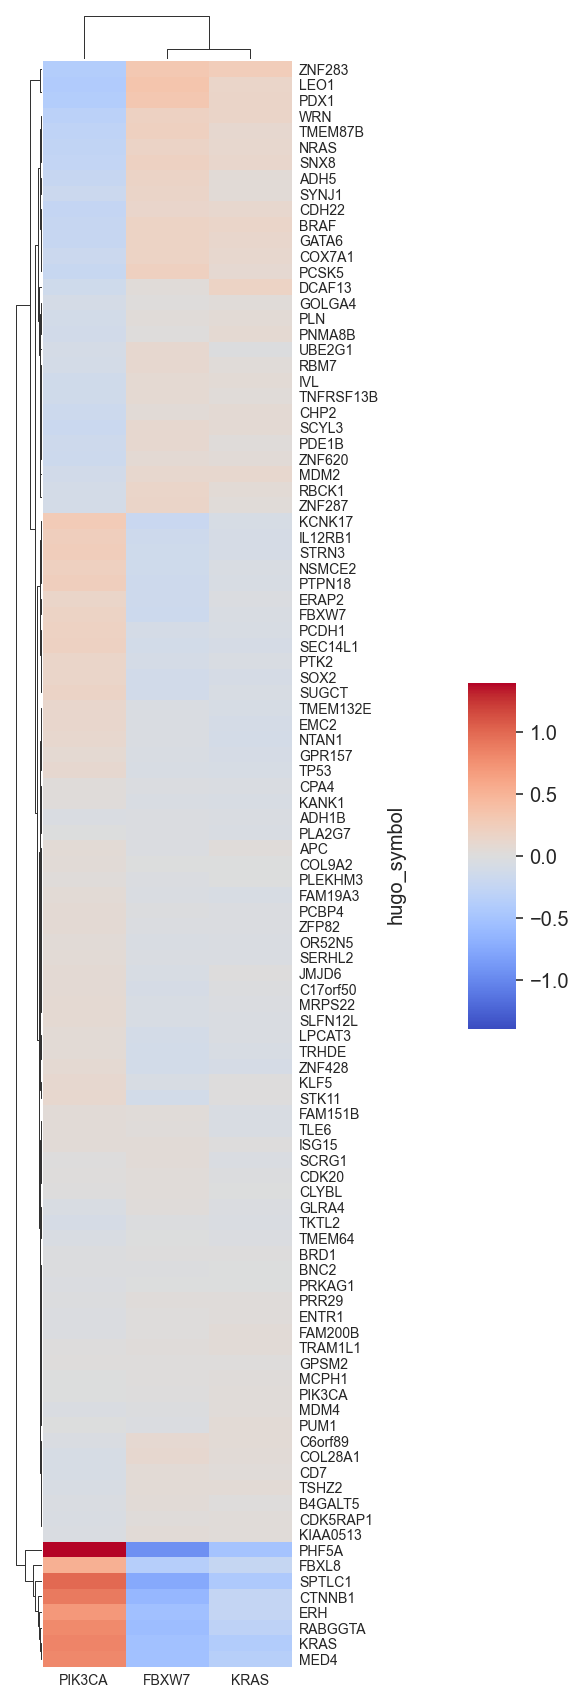

In [22]:
w_post_summary = (
    az.summary(trace, var_names="w", kind="stats")
    .pipe(extract_coords_param_names, names=["hugo_symbol", "cancer_gene"])
    .pivot_wider("hugo_symbol", names_from="cancer_gene", values_from="mean")
    .set_index("hugo_symbol")
)

vmax = np.abs(w_post_summary.values).max()

figsize = (3.3, 12)
dendro_ratio = (0.1, figsize[0] * 0.1 / figsize[1])
cm = sns.clustermap(
    w_post_summary,
    z_score=None,
    cmap="coolwarm",
    vmin=-vmax,
    vmax=vmax,
    figsize=figsize,
    dendrogram_ratio=dendro_ratio,
    cbar_pos=(1, 0.4, 0.1, 0.2),
    yticklabels=1,
)
cm.ax_heatmap.tick_params("both", labelsize=7, size=0)
plt.show()

In [23]:
pik3ca_hits = w_post_summary.sort_values("PIK3CA").query("PIK3CA > 0.5").index.tolist()
pik3ca_hits

['FBXL8', 'ERH', 'RABGGTA', 'MED4', 'KRAS', 'CTNNB1', 'SPTLC1', 'PHF5A']

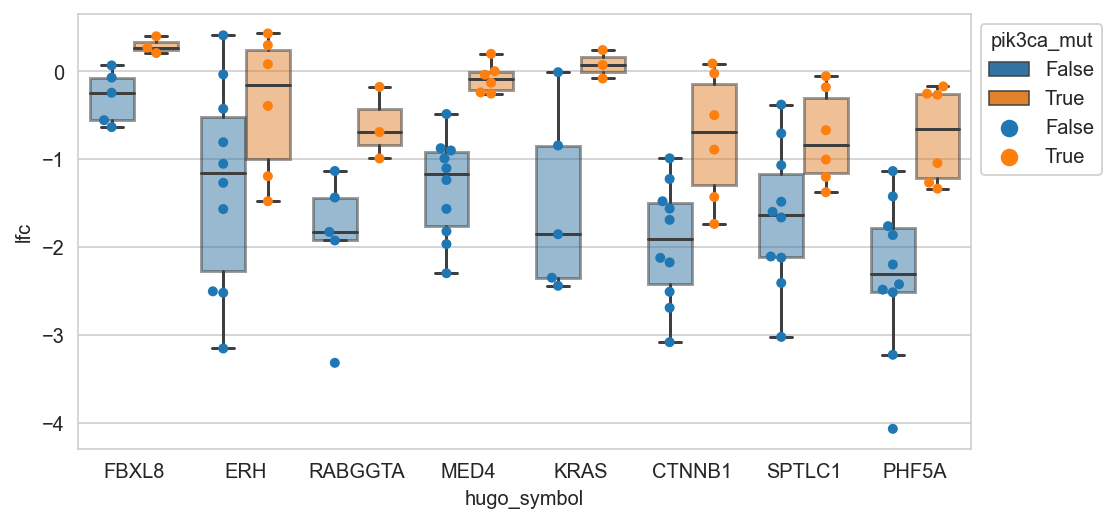

In [24]:
pik3ca_mut_map = (
    crc_data.copy()
    .query("hugo_symbol == 'PIK3CA'")[["depmap_id", "is_mutated"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .rename(columns={"is_mutated": "pik3ca_mut"})
)

pik3ca_hits_data = (
    crc_data.copy()
    .filter_column_isin("hugo_symbol", pik3ca_hits)
    .merge(pik3ca_mut_map, on="depmap_id")
    .reset_index(drop=True)
    .assign(
        hugo_symbol=lambda d: pd.Categorical(
            d["hugo_symbol"], categories=pik3ca_hits, ordered=True
        )
    )
)

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    data=pik3ca_hits_data,
    x="hugo_symbol",
    y="lfc",
    hue="pik3ca_mut",
    dodge=True,
    ax=ax,
    flierprops={"markersize": 0},
    boxprops={"alpha": 0.5},
)
sns.swarmplot(
    data=pik3ca_hits_data, x="hugo_symbol", y="lfc", hue="pik3ca_mut", dodge=True, ax=ax
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

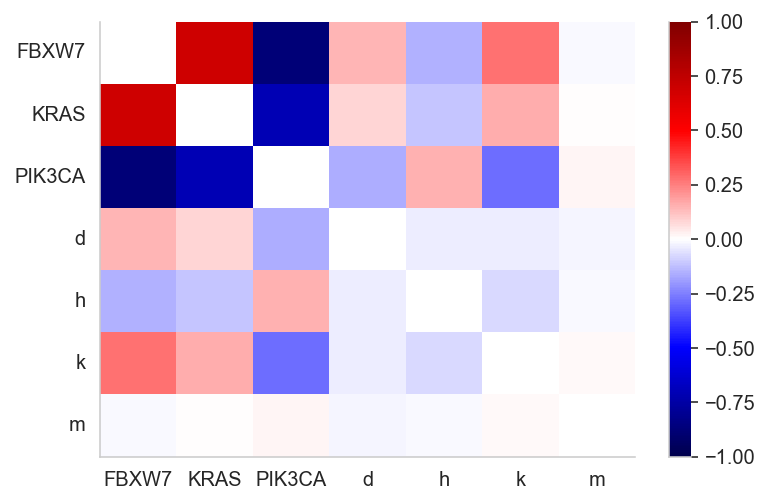

In [25]:
tissue_var_names = ["d", "h", "k", "m"] + list(
    trace.posterior.coords["cancer_gene"].values
)
gene_vars_corr = (
    az.summary(trace, "genes_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["var1", "var2"])
    .astype({"var1": int, "var2": int})
    .assign(
        var1=lambda d: [tissue_var_names[i] for i in d["var1"]],
        var2=lambda d: [tissue_var_names[i] for i in d["var2"]],
    )
)
gene_vars_corr.loc[gene_vars_corr["var1"] == gene_vars_corr["var2"], "mean"] = np.nan
gene_vars_corr = gene_vars_corr.pivot_wider(
    "var1", names_from="var2", values_from="mean"
).set_index("var1")

hm = sns.heatmap(gene_vars_corr, cmap="seismic", vmin=-1, vmax=1)
sns.despine()
hm.set_xlabel(None)
hm.set_ylabel(None)
plt.show()

---

In [29]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 10.99 minutes


In [30]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2022-07-11

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: jhcookmac.harvardsecure.wireless.med.harvard.edu

Git branch: simplify

pandas    : 1.4.3
numpy     : 1.23.0
matplotlib: 3.5.2
seaborn   : 0.11.2
pymc      : 4.0.1
plotnine  : 0.0.0
arviz     : 0.12.1

